In [1]:
import ROOT as rt
import root_numpy as rtnp
import numpy as np
from matplotlib import pyplot as plt
from histo_utilities import create_TH1D, create_TH2D, std_color_list

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.13/02


In [2]:
fpath = {}
tree = {}
process = {}
process_short = {}

fpath['m500ctau1000'] = '/home/cms/Desktop/LLP/jetNtuple_4jet/jetNtuple_M-500_CTau-1000mm.root'
fpath['m500ctau30'] = '/home/cms/Desktop/LLP/jetNtuple_4jet/jetNtuple_M-500_CTau-30mm.root'
# fpath['QCD300to500'] = '/home/cms/Desktop/LLP/jetNtuple_4jet/jetNtuple_QCD_HT300to500.root'

process['glueBall'] = 'pp #rightarrow h*h* #rightarrow jj#nu#nu'
process_short['glueBall'] = 'pp #rightarrow h*h* #rightarrow jj#nu#nu'


for k,v in fpath.iteritems():
    print k, v
    tree[k] = rtnp.root2array(v)
    #tree[k] = rtnp.tree2array(v)
    #jet_max_pt_array = [np.max(x) for x in tree[k]["jetPt"]]
    a = tree[k]["jetPt"]
    print a[:-1][0]

m500ctau30 /home/cms/Desktop/LLP/jetNtuple_4jet/jetNtuple_M-500_CTau-30mm.root
[245.10352  224.2073   192.44597   50.55233   16.677832  14.581306
  11.624692  10.09615 ]
m500ctau1000 /home/cms/Desktop/LLP/jetNtuple_4jet/jetNtuple_M-500_CTau-1000mm.root
[527.2854   412.97708   16.819384  13.449993  10.936189  10.413826]


In [3]:
T1000 = tree['m500ctau1000']
T30 = tree['m500ctau30']
# QCD = tree['QCD300to500']

In [4]:
#get first jet pt per event
#T['jetPt'][0]
first_jet_pt = [x[0] if len(x) else -1 for x in T1000['jetPt']]
print(len(first_jet_pt))

10000


In [5]:
#get max jet pt per event, also jet[0]
T=T1000
max_jet_pt = np.array([np.max(x) if len(x) else -1 for x in T['jetPt']])
max_jet_ecal_energy = np.array([x[0] if len(x) else -1 for x in T['jet_rechit_E']])
max_jet_ecal_energy1 = np.array([x[0] if len(x) else -1 for x in T['jet_rechit_E_Ecut1']])
max_jet_ecal_energy2 = np.array([x[0] if len(x) else -1 for x in T['jet_rechit_E_Ecut2']])

assert(len(max_jet_ecal_energy) == len(max_jet_pt))
print(len(max_jet_ecal_energy))
print(len(max_jet_pt[max_jet_ecal_energy<50]))
# print max_jet_pt


10000
3562


# Matched Jets and how they change with LLP decay radius

In [19]:
# Create 2d numpy array matched-jets vs. LLP decay radius
# matched_jet = np.array([4-np.count_nonzero(x == 666) if len(x) else -1 for x in T['gLLP_daughter_match_jet_index']])
tree = [T30,T1000]
match_efficiency_llp = []
match_efficiency_event = []
gLLP_decay_radius_list = []
matched_jets_perllp_list = []
barrel_jets_perllp_list = []
for i in range(len(tree)):
    T = tree[i]
    gLLP_decay_radius = np.sqrt(np.square(T['gLLP_decay_vertex_x'])+np.square(T['gLLP_decay_vertex_y'])) # (events, 2) 2LLP
    # gLLP_decay_radius = np.reshape(gLLP_decay_radius,(-1,1)) # flatten (2*events, 1)
    gLLP_daughter_match_jet_index = T['gLLP_daughter_match_jet_index']
    daughter_eta =  T['gLLP_daughter_eta']
    gLLP_daughter_travel_time = T['gLLP_daughter_travel_time']

    # number of matched/barrel jets for each LLP
    # matched_jets.shape = (events,2)

    matched_jets = np.logical_and(np.logical_not( gLLP_daughter_travel_time == -666), np.logical_not( gLLP_daughter_match_jet_index == 666))
    matched_jets_perllp = np.column_stack((np.count_nonzero(matched_jets[:,:2],axis=1),np.count_nonzero(matched_jets[:,2:],axis=1)))
    matched_jets_perevent = np.count_nonzero(matched_jets,axis=1)
    # barrel_jets.shape = (events,2)
    LLP_daughter_barrel = np.logical_not( gLLP_daughter_travel_time == -666) #shape: (events, 4)
    barrel_jets_perllp = np.column_stack((np.count_nonzero(LLP_daughter_barrel[:,:2],axis=1),np.count_nonzero(LLP_daughter_barrel[:,2:],axis=1)))
    barrel_jets_perevent = np.count_nonzero(LLP_daughter_barrel,axis=1)

    # now both matched_jets_perllp and barrel_jets_perllp are flattened with shape: (LLP#, )
    # gLLP_decay_radius and match_efficiency also have shape (LLP#,)
    matched_jets_perllp = matched_jets_perllp[barrel_jets_perllp>0]
    gLLP_decay_radius = gLLP_decay_radius[barrel_jets_perllp > 0] #llp decay radius of llp with at least one barrel
    barrel_jets_perllp = barrel_jets_perllp [barrel_jets_perllp > 0]
    assert(matched_jets_perllp.shape == gLLP_decay_radius.shape == barrel_jets_perllp.shape)
    barrel_jets_perllp_list.append(barrel_jets_perllp)
    matched_jets_perllp_list.append(matched_jets_perllp)
    match_efficiency_llp.append(np.divide(1.0* matched_jets_perllp , barrel_jets_perllp)) #match efficiency for each LLP
    gLLP_decay_radius_list.append(gLLP_decay_radius)
    ## per event
    matched_jets_perevent = matched_jets_perevent[barrel_jets_perevent>0]
    barrel_jets_perevent = barrel_jets_perevent [barrel_jets_perevent>0]
    assert(barrel_jets_perevent.shape == matched_jets_perevent.shape)
    match_efficiency_event.append(np.divide(1.0* matched_jets_perevent , barrel_jets_perevent)) #match efficiency for each LLP
#     print(np.count_nonzero(barrel_jets_perevent),np.count_nonzero(matched_jets_perevent))

print(matched_jets_perllp.shape)
print(gLLP_decay_radius.shape)
print(np.sum(match_efficiency_event[0])/np.size(match_efficiency_event[0]))
print(np.count_nonzero(barrel_jets_perllp_list[0] == 0))
print(barrel_jets_perllp_list[1])

(17784,)
(17784,)
0.2863502722929404
0
[2 2 2 ... 1 2 1]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: match_efficiency (Potential memory leak).
Info in <TCanvas::Print>: pdf file barrel_matched.pdf has been created


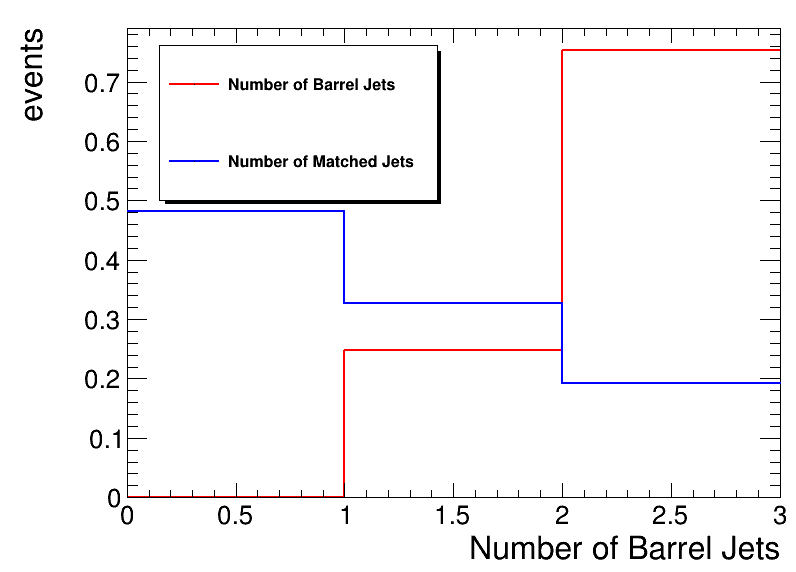

In [20]:
c = rt.TCanvas('c','c', 800, 600)
h = {}
leg = rt.TLegend(0.2,0.65,0.55,0.92)
# leg.SetTextFont(42)
leg.SetTextSize(0.03)
leg.SetEntrySeparation(0.01)
h['barrel'] = create_TH1D( barrel_jets_perllp_list[1], axis_title=['Number of Barrel Jets', 'Percentage of matched jets'], name='match_efficiency', binning=[3,0,3])
h['barrel'].SetLineColor(2)
h['matched'] = create_TH1D( matched_jets_perllp_list[1], axis_title=['Number of Matched Jets', 'events'], name='match_efficiency', binning=[3,0,3])
h['matched'].SetLineColor(4)
# c.SetLogy()
# h['match_efficiency2'].GetYaxis().SetRangeUser(0,1.0)
leg.AddEntry(h['barrel'],'Number of Barrel Jets')
leg.AddEntry(h['matched'],'Number of Matched Jets')

h['barrel'].DrawNormalized()
h['matched'].DrawNormalized('same')
leg.Draw()
c.Draw()
c.SaveAs("barrel_matched.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: match_efficiency (Potential memory leak).
Info in <TCanvas::Print>: pdf file match_efficiency.pdf has been created


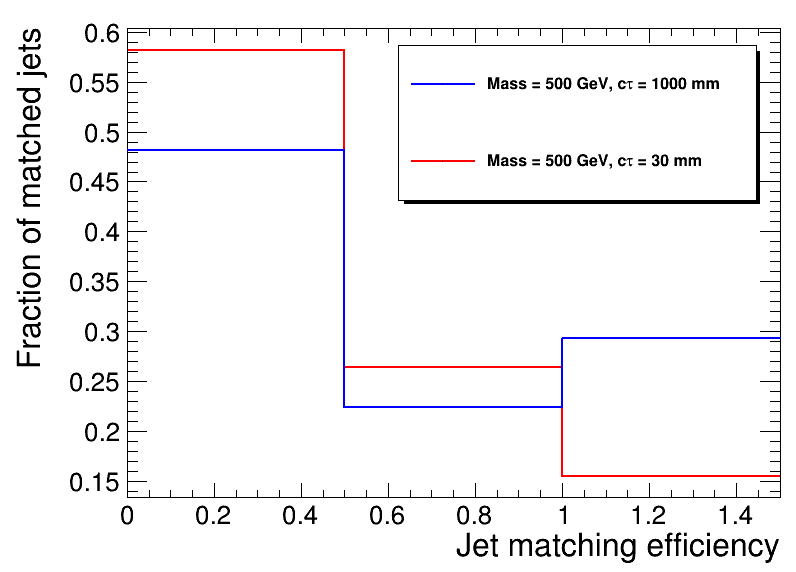

In [34]:
c = rt.TCanvas('c','c', 800, 600)
h = {}
leg = rt.TLegend(0.5,0.65,0.95,0.92)
# leg.SetTextFont(42)
leg.SetTextSize(0.03)
leg.SetEntrySeparation(0.01)
h['match_efficiency1'] = create_TH1D( match_efficiency_llp[0], axis_title=['Jet matching efficiency', 'Fraction of matched jets'], name='match_efficiency', binning=[3,0,1.5])
h['match_efficiency1'].SetLineColor(2)
h['match_efficiency2'] = create_TH1D( match_efficiency_llp[1], axis_title=['Jet matching efficiency', 'Fraction of matched jets'], name='match_efficiency', binning=[3,0,1.5])
h['match_efficiency2'].SetLineColor(4)
# c.SetLogy()
# h['match_efficiency2'].GetYaxis().SetRangeUser(0,1.0)
leg.AddEntry(h['match_efficiency2'],'Mass = 500 GeV, c#tau = 1000 mm')
leg.AddEntry(h['match_efficiency1'],'Mass = 500 GeV, c#tau = 30 mm')

h['match_efficiency1'].DrawNormalized()
h['match_efficiency2'].DrawNormalized('same')
leg.Draw()
c.Draw()
c.SaveAs("match_efficiency.pdf")

((19468,), (19468,))
16743.0
893.0
148.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file matchjet_llpdecay.pdf has been created


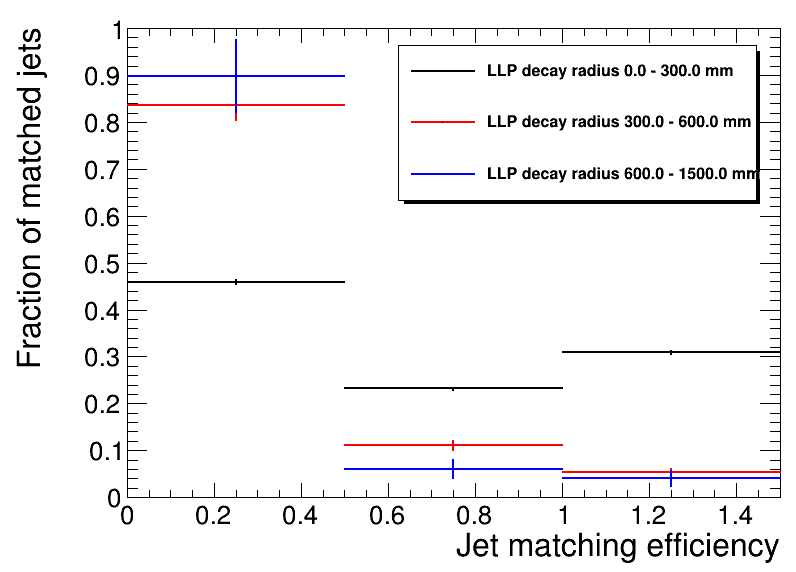

In [37]:
# Look at the number of matched jets in different LLP decay radius bin
c = rt.TCanvas('c1','c1', 800, 600)
leg = rt.TLegend(0.5,0.65,0.95,0.92)
# leg.SetTextFont(42)
leg.SetTextSize(0.03)
leg.SetEntrySeparation(0.01)
# # Create 2d numpy array matched-jets vs. LLP decay radius
h = {}
proj = []
print(match_efficiency_llp[0].shape,gLLP_decay_radius_list[0].shape)
matchjet_llpdecay = np.column_stack((match_efficiency_llp[1], gLLP_decay_radius_list[1]))
h['matchjet_llpdecay'] = create_TH2D(matchjet_llpdecay, axis_title = ['Jet matching efficiency','llp decay radius [mm]',''], binning=[3,0,1.5,50,0,1500])
bins = [1,11,21,51]
# h['matchjet_llpdecay'] = create_TH2D(matchjet_llpdecay, axis_title = ['Jet matching efficiency','llp decay radius [mm]',''], binning=[3,0,1.5,50,0,100])
# bins = [1,3,10,51]
for i in range(len(bins)-1):
    key = 'bin'+str(i)
    proj.append(h['matchjet_llpdecay'].ProjectionX("h"+str(i),bins[i],bins[i+1]-1))
    y_low = h['matchjet_llpdecay'].GetYaxis().GetBinLowEdge(bins[i])
    y_up = h['matchjet_llpdecay'].GetYaxis().GetBinLowEdge(bins[i+1]-1)+h['matchjet_llpdecay'].GetYaxis().GetBinWidth(1)
    leg.AddEntry(proj[i],'LLP decay radius '+str(y_low)+' - '+str(y_up)+' mm')

proj[0].GetYaxis().SetTitle("Fraction of matched jets")
# proj[0].GetYaxis().SetRangeUser(0,2000)
for i in range(len(bins)-1):
    proj[i].SetLineColor(i+1)
    print(proj[i].Integral())
    proj[i].Scale(1./proj[i].Integral())
    proj[i].GetYaxis().SetRangeUser(0,1)

    if i == 0:
        proj[i].DrawCopy()
    if i == 2:
        proj[i].SetLineColor(4)
    proj[i].DrawCopy('SAME')
# proj[2].GetYaxis().SetRangeUser(0,100)

# h1.Scale(1./h1.Integral())
leg.Draw()
# # c.SetLogy()
# # c.SetLogz()
c.Draw()
# print(h['matchjet_llpdecay'].GetYaxis().GetBinCenter(bin_low))
# y_low = h['matchjet_llpdecay'].GetYaxis().GetBinCenter(bin_low)
# y_up = h['matchjet_llpdecay'].GetYaxis().GetBinCenter(bin_up)
c.SaveAs('matchjet_llpdecay.pdf')


# Number of Rechits

In [24]:
T=T1000

energy_cut = 1.0
#     n_rechits = np.array( [x if len(x) else -1 for x in T['jet_n_rechits']]) 
n_rechits = [] #n_rechits of matched and barrel jets
n_rechits_qcd = [] #n_rechits of matched and barrel jets
n_rechits_T1000 = [] #n_rechits of matched and barrel jets
n_rechits_T30 = [] #n_rechits of matched and barrel jets

n_rechits_llpdecay = [] # rechits and the corresponding LLP decay length

gLLP_decay_radius = np.sqrt(np.square(T['gLLP_decay_vertex_x'])+np.square(T['gLLP_decay_vertex_y'])) # (events, 2) 2LLP
gLLP_daughter_match_jet_index = T['gLLP_daughter_match_jet_index']
gLLP_daughter_travel_time = T['gLLP_daughter_travel_time']
rechits_E =  T['jet_rechits_E']

# matched_jets.shape = (events,4), logical whether the jet is matched and hit barrel
matched_jets = np.logical_and(np.logical_not( gLLP_daughter_travel_time == -666), np.logical_not( gLLP_daughter_match_jet_index == 666))
gLLP_daughter_match_jet_index = gLLP_daughter_match_jet_index[matched_jets]


for i in range(len(T['gLLP_daughter_match_jet_index'])): #loop through each event
    for j in range(4): #loop through each gen jet
        index = T['gLLP_daughter_match_jet_index'][i][j]
        if not index == 666 and matched_jets[i][j]:
            rechits = rechits_E[i][index]
            rechits = np.count_nonzero(rechits >= energy_cut)
            if j <= 1:
                llpid = 0
            else:
                llpid = 1
            n_rechits.append(rechits)
            n_rechits_llpdecay.append([rechits, gLLP_decay_radius[i,llpid]])
assert(len(n_rechits) == len(gLLP_daughter_match_jet_index))
n_rechits_llpdecay = np.array(n_rechits_llpdecay)
print(n_rechits_llpdecay.shape)

#QCD
# rechits_E_qcd =  QCD['jet_rechits_E']
# for i in range(len(rechits_E_qcd)): #loop through each event
#     for j in range(len(rechits_E_qcd[i])): #loop through each jet
#         rechits = rechits_E_qcd[i][j]
#         rechits = np.count_nonzero(rechits >= energy_cut)
#         n_rechits_qcd.append(rechits)
        
        
rechits_E_T1000 =  T1000['jet_rechits_E']
for i in range(len(rechits_E_T1000)): #loop through each event
    for j in range(len(rechits_E_T1000[i])): #loop through each jet
        rechits = rechits_E_T1000[i][j]
        rechits = np.count_nonzero(rechits >= energy_cut)
        n_rechits_T1000.append(rechits)
        
rechits_E_T30 =  T30['jet_rechits_E']
for i in range(len(rechits_E_T30)): #loop through each event
    for j in range(len(rechits_E_T30[i])): #loop through each jet
        rechits = rechits_E_T30[i][j]
        rechits = np.count_nonzero(rechits >= energy_cut)
        n_rechits_T30.append(rechits)


(12626, 2)


10585.0
1516.0
18.0


Warning in <TH1D::Rebin>: ngroup=3 is not an exact divider of nbins=50.
Warning in <TH1D::Rebin>: ngroup=3 is not an exact divider of nbins=50.
Warning in <TH1D::Rebin>: ngroup=3 is not an exact divider of nbins=50.
Info in <TCanvas::Print>: pdf file rechit_llpdecay_ecut1.0.pdf has been created


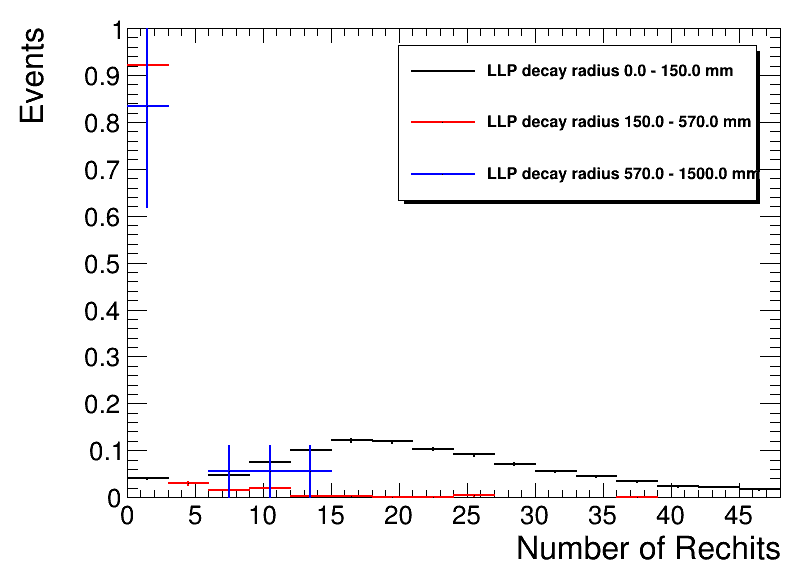

In [25]:
# Look at the number of rechits per jets in different LLP decay radius bin
c = rt.TCanvas('c1','c1', 800, 600)
leg = rt.TLegend(0.5,0.65,0.95,0.92)
# leg.SetTextFont(42)
leg.SetTextSize(0.03)
leg.SetEntrySeparation(0.01)
# # Create 2d numpy array matched-jets vs. LLP decay radius
h = {}
proj = []
bin_low, bin_up = 30,50
h['rechit_llpdecay'] = create_TH2D(n_rechits_llpdecay, axis_title = ['Number of Rechits','llp decay radius [mm]',''], binning=[50,0,50,50,0,1500])
bins = [1,6,20,51]
for i in range(len(bins)-1):
    key = 'bin'+str(i)
    proj.append(h['rechit_llpdecay'].ProjectionX("h"+str(i),bins[i],bins[i+1]-1))
    y_low = h['rechit_llpdecay'].GetYaxis().GetBinLowEdge(bins[i])
    y_up = h['rechit_llpdecay'].GetYaxis().GetBinLowEdge(bins[i+1]-1)+h['rechit_llpdecay'].GetYaxis().GetBinWidth(1)
    leg.AddEntry(proj[i],'LLP decay radius '+str(y_low)+' - '+str(y_up)+' mm')

proj[0].GetYaxis().SetTitle("Events")
proj[0].GetYaxis().SetRangeUser(0,1)
for i in range(len(bins)-1):
    proj[i].SetLineColor(i+1)
    proj[i].Rebin(3)
    print(proj[i].Integral())
    proj[i].Scale(1./proj[i].Integral())
    proj[i].GetYaxis().SetRangeUser(0,1)

    if i == 0:
        proj[i].DrawCopy()
    if i == 2:
        proj[i].SetLineColor(4)
#         proj[i].Rebin(3)
        proj[i].GetYaxis().SetRangeUser(0,1)

    proj[i].DrawCopy('SAME')
proj[2].GetYaxis().SetRangeUser(0,1)

# h1.Scale(1./h1.Integral())
leg.Draw()
# # c.SetLogy()
# # c.SetLogz()
c.Draw()
# print(h['matchjet_llpdecay'].GetYaxis().GetBinCenter(bin_low))
# y_low = h['matchjet_llpdecay'].GetYaxis().GetBinCenter(bin_low)
# y_up = h['matchjet_llpdecay'].GetYaxis().GetBinCenter(bin_up)
c.SaveAs('rechit_llpdecay_ecut'+str(energy_cut)+'.pdf')


In [26]:
c = rt.TCanvas('c','c', 800, 600)
h = {}
print(max_rechit_E.shape,max_jet_ecal_energy.shape)
h['max_jet_ecal'] = create_TH1D( max_jet_ecal_energy, axis_title=['Max jet ECAL Energy [GeV]', 'events'], name='max_jet_ecal', binning=[200,0,2000])
h['max_jet_ecal'].SetLineColor(4)
c.SetLogy()
h['max_jet_ecal'].Draw()
c.Draw()
c.SaveAs("max_jet_ecal_energy.pdf")

NameError: name 'max_rechit_E' is not defined

In [27]:
c = rt.TCanvas('c','c', 800, 600)
h = {}
h['max_jet_pt'] = create_TH1D(max_jet_pt, axis_title=['Max jet p_{T}', 'events'], name='max_jet_pt', binning=[200,0,2000])
h['max_jet_pt'].SetLineColor(4)
c.SetLogy()
h['max_jet_pt'].Draw()
c.Draw()
c.SaveAs("max_jet_pt.pdf")

NameError: name 'max_jet_pt' is not defined

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


In [28]:
c = rt.TCanvas('c','c', 800, 600)
h = {}

h['n_rechits_qcd'] = create_TH1D(n_rechits_qcd, axis_title=['Number of Rechits', 'events'], name='n_rechits', binning=[100,0,100])
h['n_rechits_qcd'].SetLineColor(4)
h['n_rechits_qcd'].Scale(1./h['n_rechits_qcd'].Integral())
# h['n_rechits_qcd'].GetYaxis().SetRangeUser(0,1)
h['n_rechits_qcd'].Draw()

h['n_rechits_T1000'] = create_TH1D(n_rechits_T1000, axis_title=['Number of Rechits', 'events'], name='n_rechits_T1000', binning=[100,0,100])
h['n_rechits_T1000'].SetLineColor(1)
h['n_rechits_T1000'].Scale(1./h['n_rechits_T1000'].Integral())
h['n_rechits_T1000'].Draw('SAME')

h['n_rechits_T30'] = create_TH1D(n_rechits_T30, axis_title=['Number of Rechits', 'events'], name='n_rechits_T30', binning=[100,0,100])
h['n_rechits_T30'].SetLineColor(2)
h['n_rechits_T30'].Scale(1./h['n_rechits_T30'].Integral())
h['n_rechits_T30'].Draw('same')

leg = rt.TLegend(0.5,0.70,0.95,0.92)
# leg.SetTextFont(42)
leg.SetTextSize(0.03)
leg.AddEntry(h['n_rechits_qcd'],"QCD HT 300-500 GeV")
leg.AddEntry(h['n_rechits_T30'],"Mass = 500 GeV, c#tau = 30 mm")
leg.AddEntry(h['n_rechits_T1000'],"Mass = 500 GeV, c#tau = 1000 mm")

c.SetLogy()
leg.Draw()
c.Draw()
c.SaveAs("n_rechits_all.pdf")

ZeroDivisionError: float division by zero

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file gLLP_decay_radius.pdf has been created


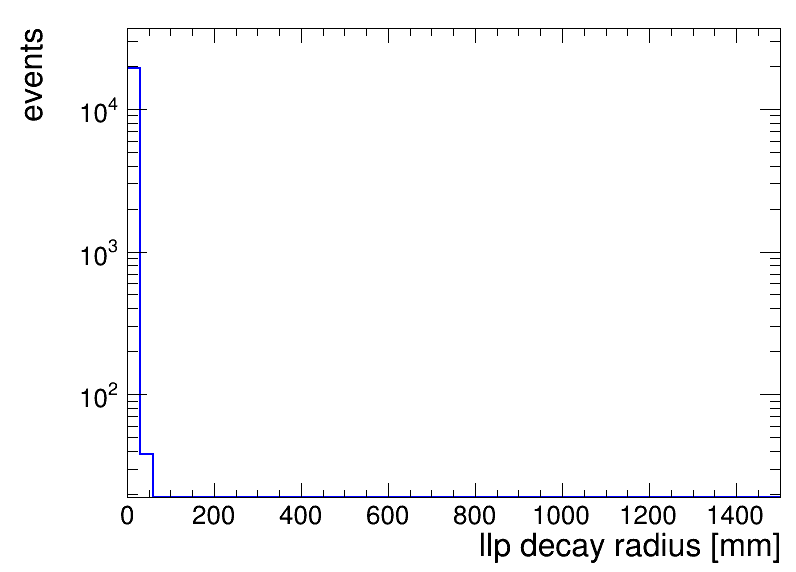

In [31]:
c = rt.TCanvas('c','c', 800, 600)
# print(np.mean(gLLP_decay_radius[:,0],axis=1))
h = {}
h['gLLP_decay_radius'] = create_TH1D(gLLP_decay_radius_list[0] , axis_title=['llp decay radius [mm]', 'events'], name='gLLP_decay_radius', binning=[50,0,1500])
h['gLLP_decay_radius'].SetLineColor(4)

c.SetLogy()
h['gLLP_decay_radius'].Draw()
c.Draw()
c.SaveAs("gLLP_decay_radius.pdf")


# Create 2d numpy array n_rechits vs. max_rechits# Create 2d numpy array with n_rechits vs. LLP decay radius

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


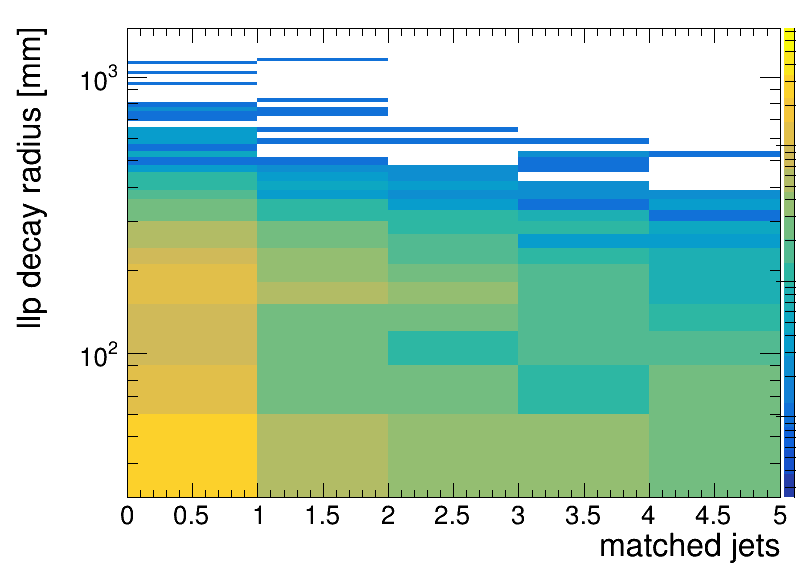

In [97]:
c = rt.TCanvas('c1','c1', 800, 600)

# Create 2d numpy array matched-jets vs. LLP decay radius
h = {}

h['jet_llpdecay'] = create_TH2D(n_rechits_llpdecay, axis_title = ['matched jets','llp decay radius [mm]',''], binning=[5,0,5,50,0,1500])
h['jet_llpdecay'].Draw('colz')
c.SetLogy()
c.SetLogz()
c.Draw()

8064.0
158.0
15.0


Error in <THistPainter::PaintInit>: Cannot set Y axis to log scale
Error in <THistPainter::PaintInit>: Cannot set Y axis to log scale
Error in <THistPainter::PaintInit>: Cannot set Y axis to log scale
Error in <THistPainter::PaintInit>: Cannot set Y axis to log scale
Error in <THistPainter::PaintInit>: Cannot set Y axis to log scale
Error in <THistPainter::PaintInit>: Cannot set Y axis to log scale
Error in <THistPainter::PaintInit>: Cannot set Y axis to log scale
Error in <THistPainter::PaintInit>: Cannot set Y axis to log scale
Info in <TCanvas::Print>: pdf file _rechit_llpdecay_ecut1.0.pdf has been created


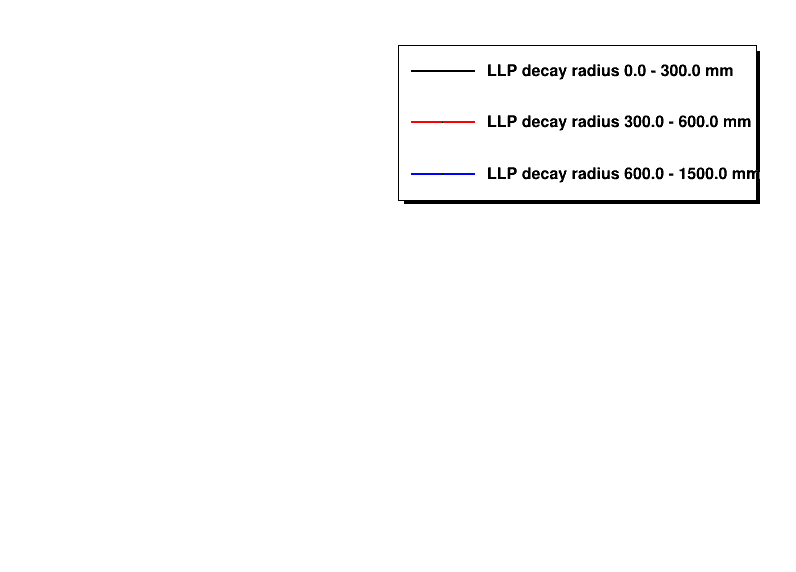

In [19]:
# Look at the number of rechits per jets in different LLP decay radius bin
c = rt.TCanvas('c1','c1', 800, 600)
leg = rt.TLegend(0.5,0.65,0.95,0.92)
# leg.SetTextFont(42)
leg.SetTextSize(0.03)
leg.SetEntrySeparation(0.01)
# # Create 2d numpy array matched-jets vs. LLP decay radius
h = {}
proj = []
bin_low, bin_up = 30,50
h['rechit_llpdecay'] = create_TH2D(n_rechits_llpdecay, axis_title = ['Number of Rechits','llp decay radius [mm]',''], binning=[60,0,60,50,0,1500])
bins = [1,11,21,51]
for i in range(len(bins)-1):
    key = 'bin'+str(i)
    proj.append(h['rechit_llpdecay'].ProjectionX("h"+str(i),bins[i],bins[i+1]-1))
    y_low = h['rechit_llpdecay'].GetYaxis().GetBinLowEdge(bins[i])
    y_up = h['rechit_llpdecay'].GetYaxis().GetBinLowEdge(bins[i+1]-1)+h['rechit_llpdecay'].GetYaxis().GetBinWidth(1)
    leg.AddEntry(proj[i],'LLP decay radius '+str(y_low)+' - '+str(y_up)+' mm')

proj[0].GetYaxis().SetTitle("Events")
proj[0].GetYaxis().SetRangeUser(0,1)
for i in range(len(bins)-1):
    proj[i].SetLineColor(i+1)
    proj[i].Rebin(3)
    print(proj[i].Integral())
    proj[i].Scale(1./proj[i].Integral())
    proj[i].GetYaxis().SetRangeUser(0,1)

    if i == 0:
        proj[i].Draw()
    if i == 2:
        proj[i].SetLineColor(4)
#         proj[i].Rebin(3)
        proj[i].GetYaxis().SetRangeUser(0,1)

    proj[i].Draw('SAME')
# proj[2].GetYaxis().SetRangeUser(0,1)

# h1.Scale(1./h1.Integral())
leg.Draw()
c.SetLogy()
# # c.SetLogz()
c.Draw()
# print(h['matchjet_llpdecay'].GetYaxis().GetBinCenter(bin_low))
# y_low = h['matchjet_llpdecay'].GetYaxis().GetBinCenter(bin_low)
# y_up = h['matchjet_llpdecay'].GetYaxis().GetBinCenter(bin_up)
c.SaveAs('_rechit_llpdecay_ecut'+str(energy_cut)+'.pdf')
